In [1]:
import pandas as pd
import numpy as np
import gc
import datetime as dt
import time
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [3]:
train=pd.read_csv('train.csv.zip')
store=pd.read_csv('store.csv.zip')
test=pd.read_csv('test.csv.zip')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(len(train))
print(len(test))

1017209
41088


In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [11]:
#store中农有promo2的公司，其promo时间段就三种
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

Part 1 train，store异常值处理

1. 将StateHoliday字段中的数值0转化为字符0

In [7]:
train['StateHoliday']=train['StateHoliday'].astype(str)

In [8]:
test['StateHoliday']=test['StateHoliday'].astype(str)

2. 删除开门营业但是没有营业额的数据点

In [9]:
#查看开门营业却没有销售额的数据点
len(train[(train['Sales']==0) & (train['Open']==1)])

54

In [10]:
abindex_1=train[(train['Sales']==0) & (train['Open']==1)].index

In [11]:
train=train.drop(abindex_1)

In [12]:
len(train)

1017155

3. 删除Sales的极值点

In [13]:
train.Sales.plot.hist(bins=40)

In [14]:
print(str(len(train[train['Sales']>20000])/len(train)*100) + '%')

0.402986762096239%


In [15]:
print(len(train[train['Sales']>20000]))
print(len(train[train['Sales']>35000]))
print(len(train[train['Sales']>40000]))

4099
18
1


In [16]:
train=train[train['Sales']<=35000]

In [17]:
len(train)

1017137

In [227]:
train.to_csv('train_0521.csv',index=False)

4. 用最大值填充CompetitionDistance的na

In [18]:
store['CompetitionDistance']=store['CompetitionDistance'].fillna(max(store['CompetitionDistance']))

5. 用最早的时间来填充CompetitionOpenSinceMonth和CompetitionOpenSinceYear

In [19]:
#观察最早的competition开始的时间
store[store['CompetitionOpenSinceYear']==min(store['CompetitionOpenSinceYear'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
814,815,a,a,590.0,1.0,1900.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [20]:
#用1900年1月份去填充na
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(1.0)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(1900.0)

In [228]:
store.to_csv('store_0521.csv',index=False)

Part 2 store表特征工程

In [35]:
train["Year"] = train["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").year)
train["Month"] = train["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").month)
train["Day"] = train["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").day)

In [70]:
train['Week']=train["Date"].apply(lambda x: int(dt.datetime.strptime(x, "%Y-%m-%d").strftime("%W")))

In [21]:
#只保留open字段为1的store来进行计算
train_open=train[train['Open']==1]

In [50]:
train_open

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31
5,6,5,2015-07-31,5651,589,1,1,0,1,2015,7,31
6,7,5,2015-07-31,15344,1414,1,1,0,1,2015,7,31
7,8,5,2015-07-31,8492,833,1,1,0,1,2015,7,31
8,9,5,2015-07-31,8565,687,1,1,0,1,2015,7,31
9,10,5,2015-07-31,7185,681,1,1,0,1,2015,7,31


In [51]:
train.StateHoliday.value_counts()

0    986095
a     20255
b      6687
c      4100
Name: StateHoliday, dtype: int64

In [52]:
train.SchoolHoliday.value_counts()

0    835431
1    181706
Name: SchoolHoliday, dtype: int64

In [4]:
store.StoreType.value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [5]:
store.Assortment.value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [7]:
store.Promo2.value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [85]:
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

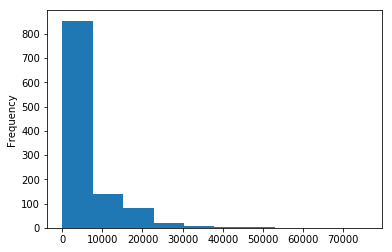

In [9]:
store.CompetitionDistance.plot.hist()

1. 生成每个店铺平均销量和顾客数

In [23]:
#每个商店的平均Sales和Customers
train_store_mean=train_open.groupby('Store')['Sales','Customers'].mean()
train_store_mean=train_store_mean.rename(columns={'Sales':'AvgSales','Customers':'AvgCustomers'})
train_store_mean['AvgSalesPerCustomer']=train_store_mean['AvgSales']/train_store_mean['AvgCustomers']

In [229]:
train_store_mean.head()

,AvgSales,AvgCustomers,AvgSalesPerCustomer
Store,,,
1,4759.096031,564.049936,8.437366
2,4953.900510,583.998724,8.482725
3,6942.568678,750.077022,9.255808
4,9638.401786,1321.752551,7.292138
5,4676.274711,537.340180,8.702634


In [24]:
#每个商店的Sales和Customers的中位数
train_store_median=train_open.groupby('Store')['Sales','Customers'].median()
train_store_median=train_store_median.rename(columns={'Sales':'MediSales','Customers':'MediCustomers'})

In [230]:
train_store_median.head()

,MediSales,MediCustomers
Store,,
1,4647.0,550.0
2,4783.0,575.5
3,6619.0,744.0
4,9430.5,1301.5
5,4616.0,564.0


In [25]:
#每个门店每周一到每周日的平均销售额和顾客数
train_store_weekday_1_mean=train_open[train_open['DayOfWeek']==1].groupby('Store')['Sales','Customers'].mean()
train_store_weekday_2_mean=train_open[train_open['DayOfWeek']==2].groupby('Store')['Sales','Customers'].mean()
train_store_weekday_3_mean=train_open[train_open['DayOfWeek']==3].groupby('Store')['Sales','Customers'].mean()
train_store_weekday_4_mean=train_open[train_open['DayOfWeek']==4].groupby('Store')['Sales','Customers'].mean()
train_store_weekday_5_mean=train_open[train_open['DayOfWeek']==5].groupby('Store')['Sales','Customers'].mean()
train_store_weekday_6_mean=train_open[train_open['DayOfWeek']==6].groupby('Store')['Sales','Customers'].mean()
train_store_weekday_7_mean=train_open[train_open['DayOfWeek']==7].groupby('Store')['Sales','Customers'].mean()

In [26]:
train_store_weekday_1_mean=train_store_weekday_1_mean.rename(columns={'Sales':'AvgSales_Day1','Customers':'AvgCustomers_Day1'})
train_store_weekday_2_mean=train_store_weekday_2_mean.rename(columns={'Sales':'AvgSales_Day2','Customers':'AvgCustomers_Day2'})
train_store_weekday_3_mean=train_store_weekday_3_mean.rename(columns={'Sales':'AvgSales_Day3','Customers':'AvgCustomers_Day3'})
train_store_weekday_4_mean=train_store_weekday_4_mean.rename(columns={'Sales':'AvgSales_Day4','Customers':'AvgCustomers_Day4'})
train_store_weekday_5_mean=train_store_weekday_5_mean.rename(columns={'Sales':'AvgSales_Day5','Customers':'AvgCustomers_Day5'})
train_store_weekday_6_mean=train_store_weekday_6_mean.rename(columns={'Sales':'AvgSales_Day6','Customers':'AvgCustomers_Day6'})
train_store_weekday_7_mean=train_store_weekday_7_mean.rename(columns={'Sales':'AvgSales_Day7','Customers':'AvgCustomers_Day7'})

In [246]:
train_store_weekday_6_mean.head()

,AvgSales_Day6,AvgCustomers_Day6
Store,,
1,4942.970149,597.552239
2,2873.104478,368.947761
3,4467.984962,511.503759
4,10113.447761,1421.529851
5,2079.104478,236.052239


In [27]:
#每个门店每周一到每周日的销售额和顾客数的中位数
train_store_weekday_1_median=train_open[train_open['DayOfWeek']==1].groupby('Store')['Sales','Customers'].median()
train_store_weekday_2_median=train_open[train_open['DayOfWeek']==2].groupby('Store')['Sales','Customers'].median()
train_store_weekday_3_median=train_open[train_open['DayOfWeek']==3].groupby('Store')['Sales','Customers'].median()
train_store_weekday_4_median=train_open[train_open['DayOfWeek']==4].groupby('Store')['Sales','Customers'].median()
train_store_weekday_5_median=train_open[train_open['DayOfWeek']==5].groupby('Store')['Sales','Customers'].median()
train_store_weekday_6_median=train_open[train_open['DayOfWeek']==6].groupby('Store')['Sales','Customers'].median()
train_store_weekday_7_median=train_open[train_open['DayOfWeek']==7].groupby('Store')['Sales','Customers'].median()

In [28]:
train_store_weekday_1_median=train_store_weekday_1_median.rename(columns={'Sales':'MediSales_Day1','Customers':'MediCustomers_Day1'})
train_store_weekday_2_median=train_store_weekday_2_median.rename(columns={'Sales':'MediSales_Day2','Customers':'MediCustomers_Day2'})
train_store_weekday_3_median=train_store_weekday_3_median.rename(columns={'Sales':'MediSales_Day3','Customers':'MediCustomers_Day3'})
train_store_weekday_4_median=train_store_weekday_4_median.rename(columns={'Sales':'MediSales_Day4','Customers':'MediCustomers_Day4'})
train_store_weekday_5_median=train_store_weekday_5_median.rename(columns={'Sales':'MediSales_Day5','Customers':'MediCustomers_Day5'})
train_store_weekday_6_median=train_store_weekday_6_median.rename(columns={'Sales':'MediSales_Day6','Customers':'MediCustomers_Day6'})
train_store_weekday_7_median=train_store_weekday_7_median.rename(columns={'Sales':'MediSales_Day7','Customers':'MediCustomers_Day7'})

In [234]:
train_store_weekday_1_median.head()

,MediSales_Day1,MediCustomers_Day1
Store,,
1,5302.5,581.0
2,6530.5,685.5
3,8993.0,857.5
4,11106.5,1447.0
5,6846.0,689.0


In [29]:
#每个门店每个月的平均销售额和顾客数
train_store_month_1_mean=train_open[train_open['Month']==1].groupby('Store')['Sales','Customers'].mean()
train_store_month_2_mean=train_open[train_open['Month']==2].groupby('Store')['Sales','Customers'].mean()
train_store_month_3_mean=train_open[train_open['Month']==3].groupby('Store')['Sales','Customers'].mean()
train_store_month_4_mean=train_open[train_open['Month']==4].groupby('Store')['Sales','Customers'].mean()
train_store_month_5_mean=train_open[train_open['Month']==5].groupby('Store')['Sales','Customers'].mean()
train_store_month_6_mean=train_open[train_open['Month']==6].groupby('Store')['Sales','Customers'].mean()
train_store_month_7_mean=train_open[train_open['Month']==7].groupby('Store')['Sales','Customers'].mean()
train_store_month_8_mean=train_open[train_open['Month']==8].groupby('Store')['Sales','Customers'].mean()
train_store_month_9_mean=train_open[train_open['Month']==9].groupby('Store')['Sales','Customers'].mean()
train_store_month_10_mean=train_open[train_open['Month']==10].groupby('Store')['Sales','Customers'].mean()
train_store_month_11_mean=train_open[train_open['Month']==11].groupby('Store')['Sales','Customers'].mean()
train_store_month_12_mean=train_open[train_open['Month']==12].groupby('Store')['Sales','Customers'].mean()
train_store_month_1_mean=train_store_month_1_mean.rename(columns={'Sales':'AvgSales_Month_1','Customers':'AvgCustomers_Month_1'})
train_store_month_2_mean=train_store_month_2_mean.rename(columns={'Sales':'AvgSales_Month_2','Customers':'AvgCustomers_Month_2'})
train_store_month_3_mean=train_store_month_3_mean.rename(columns={'Sales':'AvgSales_Month_3','Customers':'AvgCustomers_Month_3'})
train_store_month_4_mean=train_store_month_4_mean.rename(columns={'Sales':'AvgSales_Month_4','Customers':'AvgCustomers_Month_4'})
train_store_month_5_mean=train_store_month_5_mean.rename(columns={'Sales':'AvgSales_Month_5','Customers':'AvgCustomers_Month_5'})
train_store_month_6_mean=train_store_month_6_mean.rename(columns={'Sales':'AvgSales_Month_6','Customers':'AvgCustomers_Month_6'})
train_store_month_7_mean=train_store_month_7_mean.rename(columns={'Sales':'AvgSales_Month_7','Customers':'AvgCustomers_Month_7'})
train_store_month_8_mean=train_store_month_8_mean.rename(columns={'Sales':'AvgSales_Month_8','Customers':'AvgCustomers_Month_8'})
train_store_month_9_mean=train_store_month_9_mean.rename(columns={'Sales':'AvgSales_Month_9','Customers':'AvgCustomers_Month_9'})
train_store_month_10_mean=train_store_month_10_mean.rename(columns={'Sales':'AvgSales_Month_10','Customers':'AvgCustomers_Month_10'})
train_store_month_11_mean=train_store_month_11_mean.rename(columns={'Sales':'AvgSales_Month_11','Customers':'AvgCustomers_Month_11'})
train_store_month_12_mean=train_store_month_12_mean.rename(columns={'Sales':'AvgSales_Month_12','Customers':'AvgCustomers_Month_12'})

In [236]:
train_store_month_11_mean.head()

,AvgSales_Month_11,AvgCustomers_Month_11
Store,,
1,5067.607843,592.156863
2,5123.235294,580.156863
3,7098.448980,763.102041
4,9810.627451,1350.862745
5,4956.551020,550.836735


In [30]:
#每个门店每个月的销售额和顾客数的中位数
train_store_month_1_median=train_open[train_open['Month']==1].groupby('Store')['Sales','Customers'].median()
train_store_month_2_median=train_open[train_open['Month']==2].groupby('Store')['Sales','Customers'].median()
train_store_month_3_median=train_open[train_open['Month']==3].groupby('Store')['Sales','Customers'].median()
train_store_month_4_median=train_open[train_open['Month']==4].groupby('Store')['Sales','Customers'].median()
train_store_month_5_median=train_open[train_open['Month']==5].groupby('Store')['Sales','Customers'].median()
train_store_month_6_median=train_open[train_open['Month']==6].groupby('Store')['Sales','Customers'].median()
train_store_month_7_median=train_open[train_open['Month']==7].groupby('Store')['Sales','Customers'].median()
train_store_month_8_median=train_open[train_open['Month']==8].groupby('Store')['Sales','Customers'].median()
train_store_month_9_median=train_open[train_open['Month']==9].groupby('Store')['Sales','Customers'].median()
train_store_month_10_median=train_open[train_open['Month']==10].groupby('Store')['Sales','Customers'].median()
train_store_month_11_median=train_open[train_open['Month']==11].groupby('Store')['Sales','Customers'].median()
train_store_month_12_median=train_open[train_open['Month']==12].groupby('Store')['Sales','Customers'].median()
train_store_month_1_median=train_store_month_1_median.rename(columns={'Sales':'MediSales_Month_1','Customers':'MediCustomers_Month_1'})
train_store_month_2_median=train_store_month_2_median.rename(columns={'Sales':'MediSales_Month_2','Customers':'MediCustomers_Month_2'})
train_store_month_3_median=train_store_month_3_median.rename(columns={'Sales':'MediSales_Month_3','Customers':'MediCustomers_Month_3'})
train_store_month_4_median=train_store_month_4_median.rename(columns={'Sales':'MediSales_Month_4','Customers':'MediCustomers_Month_4'})
train_store_month_5_median=train_store_month_5_median.rename(columns={'Sales':'MediSales_Month_5','Customers':'MediCustomers_Month_5'})
train_store_month_6_median=train_store_month_6_median.rename(columns={'Sales':'MediSales_Month_6','Customers':'MediCustomers_Month_6'})
train_store_month_7_median=train_store_month_7_median.rename(columns={'Sales':'MediSales_Month_7','Customers':'MediCustomers_Month_7'})
train_store_month_8_median=train_store_month_8_median.rename(columns={'Sales':'MediSales_Month_8','Customers':'MediCustomers_Month_8'})
train_store_month_9_median=train_store_month_9_median.rename(columns={'Sales':'MediSales_Month_9','Customers':'MediCustomers_Month_9'})
train_store_month_10_median=train_store_month_10_median.rename(columns={'Sales':'MediSales_Month_10','Customers':'MediCustomers_Month_10'})
train_store_month_11_median=train_store_month_11_median.rename(columns={'Sales':'MediSales_Month_11','Customers':'MediCustomers_Month_11'})
train_store_month_12_median=train_store_month_12_median.rename(columns={'Sales':'MediSales_Month_12','Customers':'MediCustomers_Month_12'})

In [237]:
train_store_month_12_median.head()

,MediSales_Month_12,MediCustomers_Month_12
Store,,
1,6293.0,716.0
2,5999.0,670.0
3,8300.0,935.0
4,11953.0,1569.0
5,5516.0,602.0


In [31]:
# groupby得到stateholiday和schoolday的平均销量和顾客数
train_store_stateholiday_0_mean=train_open[train_open['StateHoliday']=='0'].groupby('Store')['Sales','Customers'].mean()
train_store_stateholiday_a_mean=train_open[train_open['StateHoliday']=='a'].groupby('Store')['Sales','Customers'].mean()
train_store_stateholiday_b_mean=train_open[train_open['StateHoliday']=='b'].groupby('Store')['Sales','Customers'].mean()
train_store_stateholiday_c_mean=train_open[train_open['StateHoliday']=='c'].groupby('Store')['Sales','Customers'].mean()
train_store_stateholiday_0_mean=train_store_stateholiday_0_mean.rename(columns={'Sales':'AvgSales_StaHoliday_0','Customers':'AvgCustomers_StaHoliday_0'})
train_store_stateholiday_a_mean=train_store_stateholiday_a_mean.rename(columns={'Sales':'AvgSales_StaHoliday_a','Customers':'AvgCustomers_StaHoliday_a'})
train_store_stateholiday_b_mean=train_store_stateholiday_b_mean.rename(columns={'Sales':'AvgSales_StaHoliday_b','Customers':'AvgCustomers_StaHoliday_b'})
train_store_stateholiday_c_mean=train_store_stateholiday_c_mean.rename(columns={'Sales':'AvgSales_StaHoliday_c','Customers':'AvgCustomers_StaHoliday_c'})


In [238]:
train_store_stateholiday_b_mean.head()

,AvgSales_StaHoliday_b,AvgCustomers_StaHoliday_b
Store,,
85,12534.000000,1751.666667
122,3323.000000,469.000000
209,1261.000000,135.333333
259,16679.833333,2850.666667
262,32609.666667,5064.333333


In [32]:
# groupby得到stateholiday和schoolday的平均销量和顾客数
train_store_schoolholiday_0_mean=train_open[train_open['SchoolHoliday']==0].groupby('Store')['Sales','Customers'].mean()
train_store_schoolholiday_1_mean=train_open[train_open['SchoolHoliday']==1].groupby('Store')['Sales','Customers'].mean()
train_store_schoolholiday_0_mean=train_store_schoolholiday_0_mean.rename(columns={'Sales':'AvgSales_ScHoliday_0','Customers':'AvgCustomers_ScHoliday_0'})
train_store_schoolholiday_1_mean=train_store_schoolholiday_1_mean.rename(columns={'Sales':'AvgSales_ScHoliday_1','Customers':'AvgCustomers_ScHoliday_1'})

In [239]:
train_store_schoolholiday_1_mean.head()

,AvgSales_ScHoliday_1,AvgCustomers_ScHoliday_1
Store,,
1,4796.325000,564.087500
2,5324.849673,621.771242
3,7386.743590,788.564103
4,10124.823899,1355.125786
5,4958.538462,578.711538


2. 计算每个店铺的销量和顾客数量的偏移量

In [33]:
#根据storetype,assortment level，promo2和interval进行groupby
train_store_merge=pd.merge(store,train_store_mean,left_on='Store',right_index=True,how='left')
train_store_stype_mean=train_store_merge.groupby('StoreType')['AvgSales','AvgCustomers'].mean()
train_store_stype_mean=train_store_stype_mean.rename(columns={'AvgSales':'AvgSales_Stype','AvgCustomers':'AvgCustomers_Stype'})
train_store_asslev_mean=train_store_merge.groupby('Assortment')['AvgSales','AvgCustomers'].mean()
train_store_asslev_mean=train_store_asslev_mean.rename(columns={'AvgSales':'AvgSales_Asslev','AvgCustomers':'AvgCustomers_Asslev'})
train_store_promo2_mean=train_store_merge.groupby('Promo2')['AvgSales','AvgCustomers'].mean()
train_store_promo2_mean=train_store_promo2_mean.rename(columns={'AvgSales':'AvgSales_Promo2','AvgCustomers':'AvgCustomers_Promo2'})
train_store_interval_mean=train_store_merge.groupby('PromoInterval')['AvgSales','AvgCustomers'].mean()
train_store_interval_mean=train_store_interval_mean.rename(columns={'AvgSales':'AvgSales_Interval','AvgCustomers':'AvgCustomers_Interval'})

In [240]:
train_store_stype_mean.head()

,AvgSales_Stype,AvgCustomers_Stype
StoreType,,
a,6912.844589,792.178019
b,10101.003740,1997.827807
c,6917.882808,812.092889
d,6823.620621,604.208997


In [241]:
train_store_asslev_mean.head()

,AvgSales_Asslev,AvgCustomers_Asslev
Assortment,,
a,6597.004098,740.837035
b,8558.313266,2045.993215
c,7295.648905,747.716215


In [242]:
train_store_promo2_mean.head()

,AvgSales_Promo2,AvgCustomers_Promo2
Promo2,,
0,7337.086657,836.792125
1,6550.509626,676.171283


In [243]:
train_store_interval_mean.head()

,AvgSales_Interval,AvgCustomers_Interval
PromoInterval,,
"Feb,May,Aug,Nov",6418.323651,661.443787
"Jan,Apr,Jul,Oct",6714.213634,689.135521
"Mar,Jun,Sept,Dec",6195.258062,653.261422


In [34]:
#将groupby的结果全部merge到store表中，并计算差额
train_store_merge_2=pd.merge(train_store_merge,train_store_stype_mean,left_on='StoreType',right_index=True,how='left')
train_store_merge_2=pd.merge(train_store_merge_2,train_store_interval_mean,left_on='PromoInterval',right_index=True,how='left')
train_store_merge_2=pd.merge(train_store_merge_2,train_store_asslev_mean,left_on='Assortment',right_index=True,how='left')
train_store_merge_2=pd.merge(train_store_merge_2,train_store_promo2_mean,left_on='Promo2',right_index=True,how='left')

train_store_merge_2['ST_Sales_Dev']=train_store_merge_2['AvgSales']-train_store_merge_2['AvgSales_Stype']
train_store_merge_2['ST_Customers_Dev']=train_store_merge_2['AvgCustomers']-train_store_merge_2['AvgCustomers_Stype']
train_store_merge_2['Asslev_Sales_Dev']=train_store_merge_2['AvgSales']-train_store_merge_2['AvgSales_Asslev']
train_store_merge_2['Asslev_Customers_Dev']=train_store_merge_2['AvgCustomers']-train_store_merge_2['AvgCustomers_Asslev']
train_store_merge_2['Promo2_Sales_Dev']=train_store_merge_2['AvgSales']-train_store_merge_2['AvgSales_Promo2']
train_store_merge_2['Promo2_Customers_Dev']=train_store_merge_2['AvgCustomers']-train_store_merge_2['AvgCustomers_Promo2']
train_store_merge_2['Interval_Sales_Dev']=train_store_merge_2['AvgSales']-train_store_merge_2['AvgSales_Interval']
train_store_merge_2['Interval_Customers_Dev']=train_store_merge_2['AvgCustomers']-train_store_merge_2['AvgCustomers_Interval']

In [244]:
train_store_merge_2.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,AvgSales_Promo2,AvgCustomers_Promo2,ST_Sales_Dev,ST_Customers_Dev,Asslev_Sales_Dev,Asslev_Customers_Dev,Promo2_Sales_Dev,Promo2_Customers_Dev,Interval_Sales_Dev,Interval_Customers_Dev
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,...,7337.086657,836.792125,-2158.786777,-248.042953,-1837.908067,-176.787099,-2577.990626,-272.742189,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",...,6550.509626,676.171283,-1958.944079,-208.179295,-1643.103588,-156.838310,-1596.609116,-92.172559,-1760.313124,-105.136797
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",...,6550.509626,676.171283,29.724089,-42.100998,345.564580,9.239987,392.059052,73.905739,228.355044,60.941501
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,...,7337.086657,836.792125,2720.518978,509.659662,2342.752880,574.036336,2301.315129,484.960426,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,...,7337.086657,836.792125,-2236.569878,-254.837840,-1920.729387,-203.496855,-2660.811945,-299.451945,NaN,NaN


In [248]:
train_store_merge_2.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'AvgSales',
       'AvgCustomers', 'AvgSalesPerCustomer', 'AvgSales_Stype',
       'AvgCustomers_Stype', 'AvgSales_Interval', 'AvgCustomers_Interval',
       'AvgSales_Asslev', 'AvgCustomers_Asslev', 'AvgSales_Promo2',
       'AvgCustomers_Promo2', 'ST_Sales_Dev', 'ST_Customers_Dev',
       'Asslev_Sales_Dev', 'Asslev_Customers_Dev', 'Promo2_Sales_Dev',
       'Promo2_Customers_Dev', 'Interval_Sales_Dev', 'Interval_Customers_Dev'],
      dtype='object')

In [251]:
store.columns 

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [258]:
store_all_features=pd.merge(train_store_merge_2,train_store_median,
                            left_on='Store',right_index=True,how='left')

In [260]:
store_all_features=pd.merge(store_all_features,train_store_weekday_1_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_2_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_3_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_4_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_5_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_6_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_7_mean,
                            left_on='Store',right_index=True,how='left')

store_all_features=pd.merge(store_all_features,train_store_weekday_1_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_2_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_3_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_4_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_5_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_6_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_weekday_7_median,
                            left_on='Store',right_index=True,how='left')


store_all_features=pd.merge(store_all_features,train_store_month_1_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_2_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_3_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_4_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_5_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_6_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_7_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_8_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_9_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_10_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_11_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_12_mean,
                            left_on='Store',right_index=True,how='left')

store_all_features=pd.merge(store_all_features,train_store_month_1_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_2_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_3_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_4_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_5_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_6_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_7_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_8_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_9_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_10_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_11_median,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_month_12_median,
                            left_on='Store',right_index=True,how='left')







In [261]:
store_all_features=pd.merge(store_all_features,train_store_stateholiday_0_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_stateholiday_a_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_stateholiday_b_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_stateholiday_c_mean,
                            left_on='Store',right_index=True,how='left')

In [262]:
store_all_features=pd.merge(store_all_features,train_store_schoolholiday_0_mean,
                            left_on='Store',right_index=True,how='left')
store_all_features=pd.merge(store_all_features,train_store_schoolholiday_1_mean,
                            left_on='Store',right_index=True,how='left')

In [265]:
for i in store_all_features.columns:
    print(i)

Store
StoreType
Assortment
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
PromoInterval
AvgSales
AvgCustomers
AvgSalesPerCustomer
AvgSales_Stype
AvgCustomers_Stype
AvgSales_Interval
AvgCustomers_Interval
AvgSales_Asslev
AvgCustomers_Asslev
AvgSales_Promo2
AvgCustomers_Promo2
ST_Sales_Dev
ST_Customers_Dev
Asslev_Sales_Dev
Asslev_Customers_Dev
Promo2_Sales_Dev
Promo2_Customers_Dev
Interval_Sales_Dev
Interval_Customers_Dev
MediSales
MediCustomers
AvgSales_Day1
AvgCustomers_Day1
AvgSales_Day2
AvgCustomers_Day2
AvgSales_Day3
AvgCustomers_Day3
AvgSales_Day4
AvgCustomers_Day4
AvgSales_Day5
AvgCustomers_Day5
AvgSales_Day6
AvgCustomers_Day6
AvgSales_Day7
AvgCustomers_Day7
MediSales_Day1
MediCustomers_Day1
MediSales_Day2
MediCustomers_Day2
MediSales_Day3
MediCustomers_Day3
MediSales_Day4
MediCustomers_Day4
MediSales_Day5
MediCustomers_Day5
MediSales_Day6
MediCustomers_Day6
MediSales_Day7
MediCustomers_Day7
AvgSales_Month_1
AvgCustome

In [266]:
store_all_features.to_csv('store_all_features_0521.csv',index=False)

Part 3 时间的处理

In [75]:
data_all=train.append(test).reset_index(drop=True)

In [76]:
data_all["Year"] = data_all["Date"].apply(lambda x: int(dt.datetime.strptime(x, "%Y-%m-%d").year))
data_all["Month"] = data_all["Date"].apply(lambda x: int(dt.datetime.strptime(x, "%Y-%m-%d").month))
data_all["Day"] = data_all["Date"].apply(lambda x: int(dt.datetime.strptime(x, "%Y-%m-%d").day))
data_all['Week']=data_all["Date"].apply(lambda x: int(dt.datetime.strptime(x, "%Y-%m-%d").strftime("%W")))

In [77]:
data_all

,Customers,Date,Day,DayOfWeek,Id,Month,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store,Week,Year
0,555.0,2015-07-31,31,5,NaN,7,1.0,1,5263.0,1,0,1,30,2015
1,625.0,2015-07-31,31,5,NaN,7,1.0,1,6064.0,1,0,2,30,2015
2,821.0,2015-07-31,31,5,NaN,7,1.0,1,8314.0,1,0,3,30,2015
3,1498.0,2015-07-31,31,5,NaN,7,1.0,1,13995.0,1,0,4,30,2015
4,559.0,2015-07-31,31,5,NaN,7,1.0,1,4822.0,1,0,5,30,2015
5,589.0,2015-07-31,31,5,NaN,7,1.0,1,5651.0,1,0,6,30,2015
6,1414.0,2015-07-31,31,5,NaN,7,1.0,1,15344.0,1,0,7,30,2015
7,833.0,2015-07-31,31,5,NaN,7,1.0,1,8492.0,1,0,8,30,2015
8,687.0,2015-07-31,31,5,NaN,7,1.0,1,8565.0,1,0,9,30,2015
9,681.0,2015-07-31,31,5,NaN,7,1.0,1,7185.0,1,0,10,30,2015


In [79]:
data_all_store=pd.merge(data_all,store,on='Store',how='left')

In [80]:
data_all_store

,Customers,Date,Day,DayOfWeek,Id,Month,Open,Promo,Sales,SchoolHoliday,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,555.0,2015-07-31,31,5,NaN,7,1.0,1,5263.0,1,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,625.0,2015-07-31,31,5,NaN,7,1.0,1,6064.0,1,...,2015,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,821.0,2015-07-31,31,5,NaN,7,1.0,1,8314.0,1,...,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1498.0,2015-07-31,31,5,NaN,7,1.0,1,13995.0,1,...,2015,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,559.0,2015-07-31,31,5,NaN,7,1.0,1,4822.0,1,...,2015,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,589.0,2015-07-31,31,5,NaN,7,1.0,1,5651.0,1,...,2015,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,1414.0,2015-07-31,31,5,NaN,7,1.0,1,15344.0,1,...,2015,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,833.0,2015-07-31,31,5,NaN,7,1.0,1,8492.0,1,...,2015,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,687.0,2015-07-31,31,5,NaN,7,1.0,1,8565.0,1,...,2015,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,681.0,2015-07-31,31,5,NaN,7,1.0,1,7185.0,1,...,2015,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [81]:
#当前日期与竞争者开业时间的差值（几个月）
data_all_store['DeltaCompetition']=12*(data_all_store['Year']-data_all_store['CompetitionOpenSinceYear'])+(data_all_store['Month']-data_all_store['CompetitionOpenSinceMonth'])

In [83]:
#当前日期与promo2开始时间的差值（几个星期）
data_all_store['DeltaPromo2Weeks']=52*(data_all_store['Year']-data_all_store['Promo2SinceYear'])+(data_all_store['Week']-data_all_store['Promo2SinceWeek'])

In [114]:
dict_interval={'Jan,Apr,Jul,Oct':[1,4,7,10],'Feb,May,Aug,Nov':[2,5,8,11],'Mar,Jun,Sept,Dec':[3,6,9,12],np.nan:[]}

In [116]:
data_all_store['Promo2MonthList']=data_all_store['PromoInterval'].map(dict_interval)

In [131]:
data_all_store['AbsDeltaCompetition']=abs(data_all_store['DeltaCompetition'])

In [158]:
data_all_store[data_all_store['DeltaCompetition']>0]

,Customers,Date,Day,DayOfWeek,Id,Month,Open,Promo,Sales,SchoolHoliday,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DeltaCompetition,DeltaPromo2Weeks,IsPromo2Month,Promo2MonthList,AbsDeltaCompetition,BeforeCompetition
0,555.0,2015-07-31,31,5,NaN,7,1.0,1,5263.0,1,...,0,NaN,NaN,NaN,82.0,NaN,0,[],82.0,0
1,625.0,2015-07-31,31,5,NaN,7,1.0,1,6064.0,1,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",92.0,277.0,1,"[1, 4, 7, 10]",92.0,0
2,821.0,2015-07-31,31,5,NaN,7,1.0,1,8314.0,1,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",103.0,224.0,1,"[1, 4, 7, 10]",103.0,0
3,1498.0,2015-07-31,31,5,NaN,7,1.0,1,13995.0,1,...,0,NaN,NaN,NaN,70.0,NaN,0,[],70.0,0
4,559.0,2015-07-31,31,5,NaN,7,1.0,1,4822.0,1,...,0,NaN,NaN,NaN,3.0,NaN,0,[],3.0,0
5,589.0,2015-07-31,31,5,NaN,7,1.0,1,5651.0,1,...,0,NaN,NaN,NaN,19.0,NaN,0,[],19.0,0
6,1414.0,2015-07-31,31,5,NaN,7,1.0,1,15344.0,1,...,0,NaN,NaN,NaN,27.0,NaN,0,[],27.0,0
7,833.0,2015-07-31,31,5,NaN,7,1.0,1,8492.0,1,...,0,NaN,NaN,NaN,9.0,NaN,0,[],9.0,0
8,687.0,2015-07-31,31,5,NaN,7,1.0,1,8565.0,1,...,0,NaN,NaN,NaN,179.0,NaN,0,[],179.0,0
9,681.0,2015-07-31,31,5,NaN,7,1.0,1,7185.0,1,...,0,NaN,NaN,NaN,70.0,NaN,0,[],70.0,0


In [156]:
# 新增字段IsPromoMonth表明该商店该日是否在promo2的月份
# 新增两个字段，分别为“BeforeCompetition” 和 “AfterCompetition”
#都用apply函数解决字段填充      
data_all_store['BeforeCompetition']=data_all_store.apply(lambda x: 1 if int(x['DeltaCompetition'])<-12 else 
                                                         (10 if int(x['DeltaCompetition'])<-6 else 
                                                          (100 if int(x['DeltaCompetition'])<-3 else 
                                                           (1000 if int(x['DeltaCompetition'])<0 else 0))), axis=1)

In [159]:
data_all_store['AfterCompetition']=data_all_store.apply(lambda x: 1 if int(x['DeltaCompetition'])>12 else 
                                                        (10 if int(x['DeltaCompetition'])>6 else 
                                                         (100 if int(x['DeltaCompetition'])>3 else 
                                                          (1000 if int(x['DeltaCompetition'])>0 else 0))), axis=1)

In [120]:
def inmonthlist(a,b):
    return (a in b)

In [136]:
data_all_store['IsPromo2Month']=data_all_store.apply(lambda x: 1 if ((inmonthlist(x['Month'],x['Promo2MonthList'])) and (x['DeltaCompetition']>0)) else 0, axis=1)

Part 4 节假日处理

In [ ]:
#根据各家商店的营业年份，所属年份的周数来计算出本周学校的假期数、下周假期数以及上周假期数，
#创建变量 HolidayThisWeek，HolidayNextWeek，HolidayLastWeek

In [162]:
data_all_store

,Customers,Date,Day,DayOfWeek,Id,Month,Open,Promo,Sales,SchoolHoliday,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DeltaCompetition,DeltaPromo2Weeks,IsPromo2Month,Promo2MonthList,AbsDeltaCompetition,BeforeCompetition,AfterCompetition
0,555.0,2015-07-31,31,5,NaN,7,1.0,1,5263.0,1,...,NaN,NaN,NaN,82.0,NaN,0,[],82.0,0,1
1,625.0,2015-07-31,31,5,NaN,7,1.0,1,6064.0,1,...,13.0,2010.0,"Jan,Apr,Jul,Oct",92.0,277.0,1,"[1, 4, 7, 10]",92.0,0,1
2,821.0,2015-07-31,31,5,NaN,7,1.0,1,8314.0,1,...,14.0,2011.0,"Jan,Apr,Jul,Oct",103.0,224.0,1,"[1, 4, 7, 10]",103.0,0,1
3,1498.0,2015-07-31,31,5,NaN,7,1.0,1,13995.0,1,...,NaN,NaN,NaN,70.0,NaN,0,[],70.0,0,1
4,559.0,2015-07-31,31,5,NaN,7,1.0,1,4822.0,1,...,NaN,NaN,NaN,3.0,NaN,0,[],3.0,0,1000
5,589.0,2015-07-31,31,5,NaN,7,1.0,1,5651.0,1,...,NaN,NaN,NaN,19.0,NaN,0,[],19.0,0,1
6,1414.0,2015-07-31,31,5,NaN,7,1.0,1,15344.0,1,...,NaN,NaN,NaN,27.0,NaN,0,[],27.0,0,1
7,833.0,2015-07-31,31,5,NaN,7,1.0,1,8492.0,1,...,NaN,NaN,NaN,9.0,NaN,0,[],9.0,0,10
8,687.0,2015-07-31,31,5,NaN,7,1.0,1,8565.0,1,...,NaN,NaN,NaN,179.0,NaN,0,[],179.0,0,1
9,681.0,2015-07-31,31,5,NaN,7,1.0,1,7185.0,1,...,NaN,NaN,NaN,70.0,NaN,0,[],70.0,0,1


In [163]:
data_all_store.StateHoliday.value_counts()

0    1027003
a      20435
b       6687
c       4100
Name: StateHoliday, dtype: int64

In [197]:
data_all_store.SchoolHoliday.value_counts()

0    858297
1    199928
Name: SchoolHoliday, dtype: int64

In [180]:
#生成本周，上周，下周，本月，上月，下月的数据
data_all_store['ThisWeek']=data_all_store.apply(lambda x: dt.datetime.strptime(x['Date'],'%Y-%m-%d').strftime('%Y-%W'),axis=1)

In [195]:
data_all_store['LastWeek']=data_all_store.apply(lambda x: (dt.datetime.strptime(x['Date'],'%Y-%m-%d')-timedelta(weeks=1)).strftime('%Y-%W'),axis=1)
data_all_store['NextWeek']=data_all_store.apply(lambda x: (dt.datetime.strptime(x['Date'],'%Y-%m-%d')+timedelta(weeks=1)).strftime('%Y-%W'),axis=1)
data_all_store['ThisMonth']=data_all_store.apply(lambda x: dt.datetime.strptime(x['Date'],'%Y-%m-%d').strftime('%Y-%m'),axis=1)
data_all_store['LastMonth']=data_all_store.apply(lambda x: (dt.datetime.strptime(x['Date'],'%Y-%m-%d')-relativedelta(months=1)).strftime('%Y-%m'),axis=1)
data_all_store['NextMonth']=data_all_store.apply(lambda x: (dt.datetime.strptime(x['Date'],'%Y-%m-%d')+relativedelta(months=1)).strftime('%Y-%m'),axis=1)

In [211]:
data_all_store['InStateholiday']=data_all_store.apply(lambda x: 0 if x['StateHoliday']=='0' else 1,axis=1)

In [220]:
data_all_store[data_all_store['ThisWeek']=='2013-00']

,Customers,Date,Day,DayOfWeek,Id,Month,Open,Promo,Sales,SchoolHoliday,...,AbsDeltaCompetition,BeforeCompetition,AfterCompetition,ThisWeek,LastWeek,NextWeek,ThisMonth,LastMonth,NextMonth,InStateholiday
1010448,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,1,...,52.0,0,1,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010449,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,62.0,0,1,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010450,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,73.0,0,1,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010451,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,40.0,0,1,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010452,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,27.0,1,0,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010453,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,11.0,10,0,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010454,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,3.0,1000,0,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010455,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,21.0,1,0,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010456,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,149.0,0,1,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0
1010457,0.0,2013-01-06,6,7,NaN,1,0.0,0,0.0,0,...,40.0,0,1,2013-00,2012-52,2013-01,2013-01,2012-12,2013-02,0


In [216]:
#获取每周和每月的stateholiday和schoolholiday的数量
result_StHoliday_month=(data_all_store[['Date','ThisMonth','InStateholiday']].drop_duplicates(subset=['Date'],keep='last')).groupby('ThisMonth')['InStateholiday'].sum()
result_StHoliday_week=(data_all_store[['Date','ThisWeek','InStateholiday']].drop_duplicates(subset=['Date'],keep='last')).groupby('ThisWeek')['InStateholiday'].sum()
result_SchHoliday_month=(data_all_store[['Date','ThisMonth','SchoolHoliday']].drop_duplicates(subset=['Date'],keep='last')).groupby('ThisMonth')['SchoolHoliday'].sum()
result_SchHoliday_week=(data_all_store[['Date','ThisWeek','SchoolHoliday']].drop_duplicates(subset=['Date'],keep='last')).groupby('ThisWeek')['SchoolHoliday'].sum()

In [223]:
data_all_store['StateHolidayNextMonth']=data_all_store['NextMonth'].map(dict(result_StHoliday_month))
data_all_store['StateHolidayLastMonth']=data_all_store['LastMonth'].map(dict(result_StHoliday_month))
data_all_store['SchoolHolidayNextMonth']=data_all_store['NextMonth'].map(dict(result_SchHoliday_month))
data_all_store['SchoolHolidayLastMonth']=data_all_store['LastMonth'].map(dict(result_SchHoliday_month))
data_all_store['StateHolidayThisMonth']=data_all_store['ThisMonth'].map(dict(result_StHoliday_month))
data_all_store['SchoolHolidayThisMonth']=data_all_store['ThisMonth'].map(dict(result_SchHoliday_month))


In [224]:
data_all_store['StateHolidayThisWeek']=data_all_store['ThisWeek'].map(dict(result_StHoliday_week))
data_all_store['StateHolidayNextWeek']=data_all_store['NextWeek'].map(dict(result_StHoliday_week))
data_all_store['StateHolidayLastWeek']=data_all_store['LastWeek'].map(dict(result_StHoliday_week))
data_all_store['SchoolHolidayThisWeek']=data_all_store['ThisWeek'].map(dict(result_SchHoliday_week))
data_all_store['SchoolHolidayNextWeek']=data_all_store['NextWeek'].map(dict(result_SchHoliday_week))
data_all_store['SchoolHolidayLastWeek']=data_all_store['LastWeek'].map(dict(result_SchHoliday_week))

In [225]:
data_all_store.head()

,Customers,Date,Day,DayOfWeek,Id,Month,Open,Promo,Sales,SchoolHoliday,...,SchoolHolidayNextMonth,SchoolHolidayLastMonth,StateHolidayThisMonth,SchoolHolidayThisMonth,StateHolidayThisWeek,StateHolidayNextWeek,StateHolidayLastWeek,SchoolHolidayThisWeek,SchoolHolidayNextWeek,SchoolHolidayLastWeek
0,555.0,2015-07-31,31,5,NaN,7,1.0,1,5263.0,1,...,31.0,0.0,0,5,0,0.0,0.0,7,7.0,0.0
1,625.0,2015-07-31,31,5,NaN,7,1.0,1,6064.0,1,...,31.0,0.0,0,5,0,0.0,0.0,7,7.0,0.0
2,821.0,2015-07-31,31,5,NaN,7,1.0,1,8314.0,1,...,31.0,0.0,0,5,0,0.0,0.0,7,7.0,0.0
3,1498.0,2015-07-31,31,5,NaN,7,1.0,1,13995.0,1,...,31.0,0.0,0,5,0,0.0,0.0,7,7.0,0.0
4,559.0,2015-07-31,31,5,NaN,7,1.0,1,4822.0,1,...,31.0,0.0,0,5,0,0.0,0.0,7,7.0,0.0


In [267]:
data_all_store.to_csv('data_all_store_0521.csv',index=False)

#data_all_store集合了所有与日期相关的特征
#store_all_features集合了所有与store相关的特征

In [273]:
data_all_store.columns

Index(['Customers', 'Date', 'Day', 'DayOfWeek', 'Id', 'Month', 'Open', 'Promo',
       'Sales', 'SchoolHoliday', 'StateHoliday', 'Store', 'Week', 'Year',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'DeltaCompetition', 'DeltaPromo2Weeks', 'IsPromo2Month',
       'Promo2MonthList', 'AbsDeltaCompetition', 'BeforeCompetition',
       'AfterCompetition', 'ThisWeek', 'LastWeek', 'NextWeek', 'ThisMonth',
       'LastMonth', 'NextMonth', 'InStateholiday', 'StateHolidayNextMonth',
       'StateHolidayLastMonth', 'SchoolHolidayNextMonth',
       'SchoolHolidayLastMonth', 'StateHolidayThisMonth',
       'SchoolHolidayThisMonth', 'StateHolidayThisWeek',
       'StateHolidayNextWeek', 'StateHolidayLastWeek', 'SchoolHolidayThisWeek',
       'SchoolHolidayNextWeek', 'SchoolHolidayLastWeek'],
      dtype='object')

In [274]:
store_all_features.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       ...
       'AvgCustomers_StaHoliday_a', 'AvgSales_StaHoliday_b',
       'AvgCustomers_StaHoliday_b', 'AvgSales_StaHoliday_c',
       'AvgCustomers_StaHoliday_c', 'AvgSales_ScHoliday_0',
       'AvgCustomers_ScHoliday_0', 'AvgSales_ScHoliday_1',
       'AvgCustomers_ScHoliday_1', 'AssortmentEncoding'],
      dtype='object', length=120)

Part 5 独热编码以及factorize

In [275]:
#对assortment进行encoding
data_all_store.Assortment.value_counts()

a    557703
c    491799
b      8723
Name: Assortment, dtype: int64

In [270]:
dict_assortment={'a':1,'b':2,"c":3}

In [271]:
store_all_features['AssortmentEncoding']=store_all_features['Assortment'].map(dict_assortment)

In [ ]:
#data_all_store上进行encoding

In [276]:
data_all_store['AssortmentEncoding']=data_all_store['Assortment'].map(dict_assortment)

In [278]:
a=pd.get_dummies(data_all_store,columns=['DayOfWeek','StateHoliday','StoreType','PromoInterval'])  

In [282]:
a.columns

Index(['Customers', 'Date', 'Day', 'Id', 'Month', 'Open', 'Promo', 'Sales',
       'SchoolHoliday', 'Store', 'Week', 'Year', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'DeltaCompetition', 'DeltaPromo2Weeks',
       'IsPromo2Month', 'Promo2MonthList', 'AbsDeltaCompetition',
       'BeforeCompetition', 'AfterCompetition', 'ThisWeek', 'LastWeek',
       'NextWeek', 'ThisMonth', 'LastMonth', 'NextMonth', 'InStateholiday',
       'StateHolidayNextMonth', 'StateHolidayLastMonth',
       'SchoolHolidayNextMonth', 'SchoolHolidayLastMonth',
       'StateHolidayThisMonth', 'SchoolHolidayThisMonth',
       'StateHolidayThisWeek', 'StateHolidayNextWeek', 'StateHolidayLastWeek',
       'SchoolHolidayThisWeek', 'SchoolHolidayNextWeek',
       'SchoolHolidayLastWeek', 'AssortmentEncoding', 'DayOfWeek_1',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayO

#从a中删去'Customers',Date,Assortment,CompetitionOpenSinceMonth,
CompetitionOpenSinceYear,
Promo2SinceWeek,Promo2SinceYear,Promo2MonthList，DeltaCompetition，
'ThisWeek', 'LastWeek','NextWeek', 'ThisMonth', 'LastMonth', 'NextMonth','InStateholiday'

In [292]:
data_all_features=a.drop(columns=['Date','Assortment','CompetitionOpenSinceMonth',
                                  'CompetitionOpenSinceYear','Promo2SinceWeek',
                                  'Promo2SinceYear','Promo2MonthList','DeltaCompetition',
                                  'ThisWeek', 'LastWeek','NextWeek', 'ThisMonth', 'LastMonth', 
                                  'NextMonth','InStateholiday','Customers'])

In [289]:
store_all_features.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       ...
       'AvgCustomers_StaHoliday_a', 'AvgSales_StaHoliday_b',
       'AvgCustomers_StaHoliday_b', 'AvgSales_StaHoliday_c',
       'AvgCustomers_StaHoliday_c', 'AvgSales_ScHoliday_0',
       'AvgCustomers_ScHoliday_0', 'AvgSales_ScHoliday_1',
       'AvgCustomers_ScHoliday_1', 'AssortmentEncoding'],
      dtype='object', length=120)

#从store_all_features中删去Assortment,'AssortmentEncoding',StoreType,CompetitionDistance
,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval

In [286]:
store_final_features=store_all_features.drop(columns=['Assortment','AssortmentEncoding',
                                                      'StoreType','CompetitionDistance',
                                                      'CompetitionOpenSinceMonth',
                                                      'CompetitionOpenSinceYear','Promo2',
                                                      'Promo2SinceWeek','Promo2SinceYear',
                                                      'PromoInterval'])

In [293]:
data_all_features.columns

Index(['Day', 'Id', 'Month', 'Open', 'Promo', 'Sales', 'SchoolHoliday',
       'Store', 'Week', 'Year', 'CompetitionDistance', 'Promo2',
       'DeltaPromo2Weeks', 'IsPromo2Month', 'AbsDeltaCompetition',
       'BeforeCompetition', 'AfterCompetition', 'StateHolidayNextMonth',
       'StateHolidayLastMonth', 'SchoolHolidayNextMonth',
       'SchoolHolidayLastMonth', 'StateHolidayThisMonth',
       'SchoolHolidayThisMonth', 'StateHolidayThisWeek',
       'StateHolidayNextWeek', 'StateHolidayLastWeek', 'SchoolHolidayThisWeek',
       'SchoolHolidayNextWeek', 'SchoolHolidayLastWeek', 'AssortmentEncoding',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype

In [288]:
store_final_features.columns

Index(['Store', 'AvgSales', 'AvgCustomers', 'AvgSalesPerCustomer',
       'AvgSales_Stype', 'AvgCustomers_Stype', 'AvgSales_Interval',
       'AvgCustomers_Interval', 'AvgSales_Asslev', 'AvgCustomers_Asslev',
       ...
       'AvgSales_StaHoliday_a', 'AvgCustomers_StaHoliday_a',
       'AvgSales_StaHoliday_b', 'AvgCustomers_StaHoliday_b',
       'AvgSales_StaHoliday_c', 'AvgCustomers_StaHoliday_c',
       'AvgSales_ScHoliday_0', 'AvgCustomers_ScHoliday_0',
       'AvgSales_ScHoliday_1', 'AvgCustomers_ScHoliday_1'],
      dtype='object', length=110)

In [294]:
data_all_features.to_csv('data_all_final_features_0522.csv',index=False)

In [291]:
store_final_features.to_csv('store_final_features_0522.csv',index=False)